In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

np.set_printoptions(suppress=True)

%matplotlib inline

Original arrangement:  ['data/img4.jpg', 'data/img3.jpg', 'data/.ipynb_checkpoints', 'data/img2.jpg', 'data/img1.jpg']
Sorted arrangement:  ['data/img1.jpg', 'data/img2.jpg', 'data/.ipynb_checkpoints', 'data/img3.jpg', 'data/img4.jpg']

Img shape: (664 x 1000)


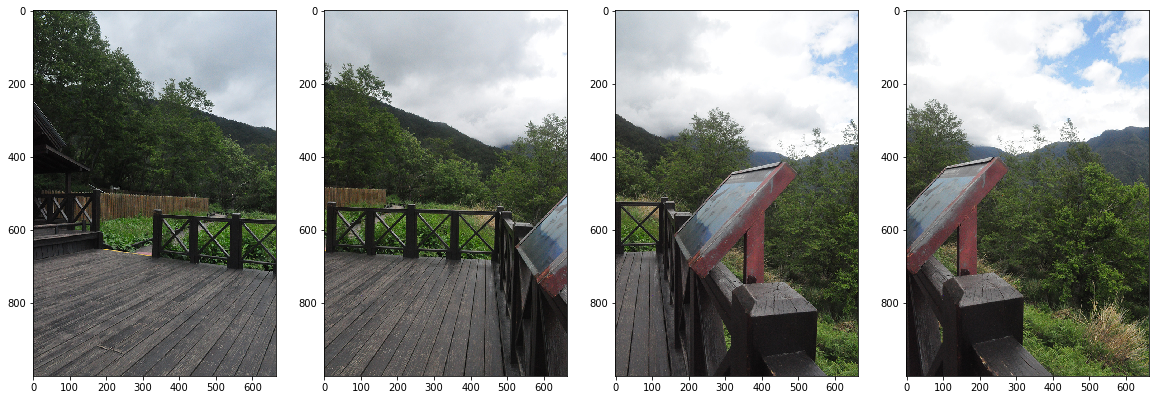

In [2]:
# (1) Load successive images (successive frames: [ fr0, fr1, fr2, fr3 ])

# Note: (taken from same viewpoint center but if the points are faw away, it does not matter much)
# Note: data source => https://github.com/SSARCandy/panoramas-image-stitching/tree/master/input_image/Xue-Mountain-Enterance

root = 'data'
files = []
for filename in os.listdir(root):
    files.append(os.path.join(root, filename))

print('Original arrangement: ', files)
# sort them in reverse
files = files[::-1]
print('Sorted arrangement: ', files)

frames = []
for idx in range(len(files)):
    if not files[idx].endswith('jpg'):
        continue
    frames.append(cv2.cvtColor(cv2.imread(files[idx], cv2.IMREAD_ANYCOLOR), cv2.COLOR_BGR2RGB).astype(np.uint8))
    
IMG_W = frames[0].shape[1]; IMG_H = frames[0].shape[0]
print(f'\nImg shape: ({IMG_W} x {IMG_H})')

N = len(frames)
fig, axes = plt.subplots(1, N, figsize=(20, 20))
for idx in range(N):
    axes[idx].imshow(frames[idx])

Number of pairs: 213


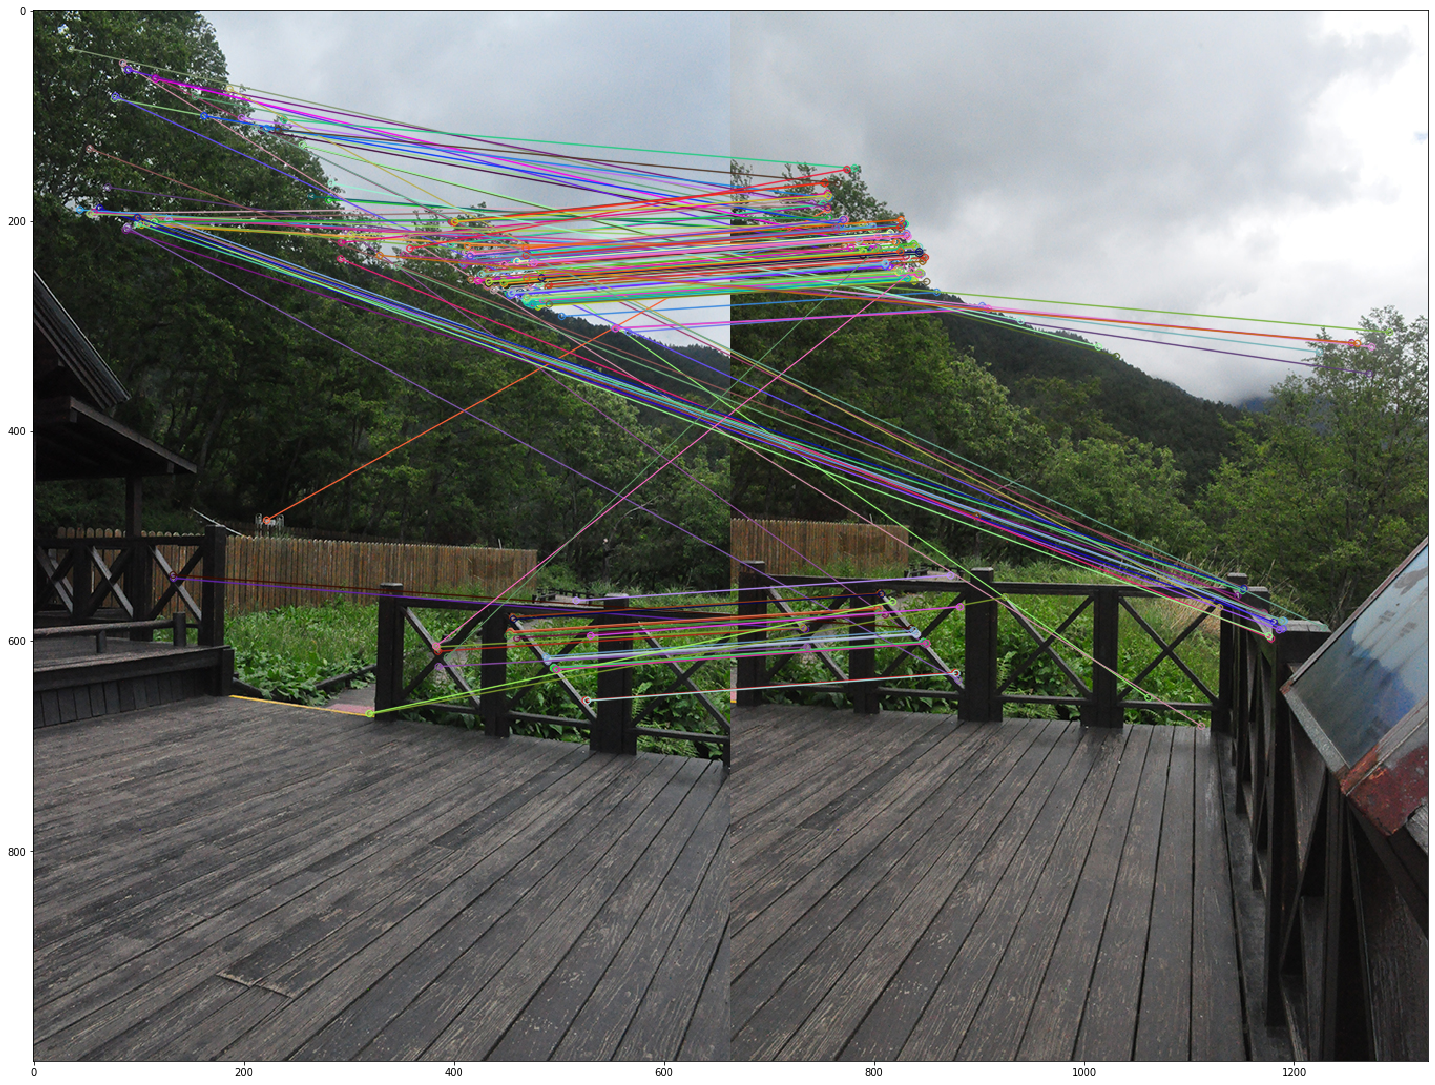

In [3]:
# (2) Find corresponding points in successive frames (relative to base frame, fr0)

orb = cv2.ORB_create()

# Note: Descriptors are rotation invariant
kpnts0, descs0 = orb.detectAndCompute(frames[0], None)
kpnts1, descs1 = orb.detectAndCompute(frames[1], None)

distance_matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches = distance_matcher.match(descs0, descs1)
#matches = sorted(matches, key=lambda m: m.distance)

print(f'Number of pairs: {len(matches)}')

result = cv2.drawMatches(frames[0], kpnts0, frames[1], kpnts1, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(25, 25))
plt.imshow(result)

0 => 454.0 x 271.0 - 147.0 x 243.0
20 => 434.0 x 247.0 - 126.0 x 217.0
40 => 413.0 x 230.0 - 106.0 x 198.0
60 => 397.20001220703125 x 222.00001525878906 - 87.84000396728516 x 184.32000732421875
80 => 116.64000701904297 x 64.80000305175781 - 139.20001220703125 x 225.60000610351562
100 => 442.3680419921875 x 235.00802612304688 - 136.5120086669922 x 207.36001586914062
120 => 471.7440490722656 x 231.55201721191406 - 164.16001892089844 x 203.90402221679688
140 => 485.22247314453125 x 275.7888488769531 - 178.32962036132812 x 250.9056396484375
160 => 497.66412353515625 x 627.0567626953125 - 184.13572692871094 x 602.173583984375
180 => 358.31817626953125 x 226.4371795654297 - 110.4000015258789 x 151.20001220703125
200 => 433.56500244140625 x 257.9891052246094 - 125.41136169433594 x 229.32363891601562

Stacked correspondances:
(213, 4)


correspondances[0]:
[454. 271. 147. 243.]


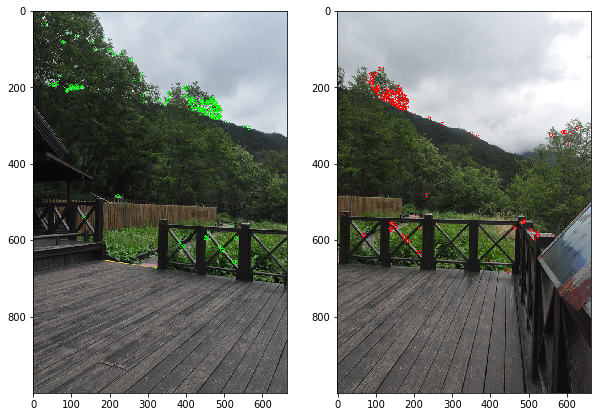

In [4]:
# (2.1) Manage the matching pairs
correspondances = []
for idx in range(len(matches)):
    match = matches[idx]
    pnt1 = kpnts0[match.queryIdx]
    pnt2 = kpnts1[match.trainIdx]
    x1, y1 = pnt1.pt
    x2, y2 = pnt2.pt
    correspondances.append([x1, y1, x2, y2])
    
    if idx % 20 == 0:
        print(f'{idx} => {x1} x {y1} - {x2} x {y2}')
    
correspondances = np.array(correspondances)
#correspondances[:, 0::2] /= IMG_W
#correspondances[:, 1::2] /= IMG_H
print(f'\nStacked correspondances:\n{correspondances.shape}\n')
print(f'\ncorrespondances[0]:\n{correspondances[0]}')
    
base = np.copy(frames[0])
for pnts in correspondances:
    base = cv2.circle(base, (int(pnts[0]), int(pnts[1])), 5, (0, 255, 0))
    
frame = np.copy(frames[1])
for pnts in correspondances:
    frame = cv2.circle(frame, (int(pnts[2]), int(pnts[3])), 5, (255, 0, 0))

fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(base)
axes[1].imshow(frame)

In [5]:
# (3) Clean outliers (mismatches) via RANSAC
num_data_pnts = correspondances.shape[0]
prob_outliers = 0.2 # e
termination_count = (1.0 - prob_outliers) * num_data_pnts # T
num_pnts_per_sample = 4 # s
p = 0.99 # probability of only inliers (1 in 100 outliers in this case)
N = np.int(np.ceil(np.log(1.0 - p) / np.log(1.0 - (1.0 - prob_outliers)**num_pnts_per_sample)))

# Note: What is the probability have to be equal to, if going through each pair?
print(f'Terminate at: {termination_count}')
print(f'N: {N}')

Terminate at: 170.4
N: 9


In [8]:
def argminwhere(mat):
    rows, cols = mat.shape
    min_vals = []
    min_coords = []
    for col in range(cols):
        min_row = np.argmin(mat[:, col])
        min_coords.append([ min_row, col ])
        min_vals.append(mat[int(min_row)][int(col)])
    
    min_val_abs = [100000, 0]
    for idx in range(len(min_vals)):
        min_val = min_vals[idx]
        if min_val < min_val_abs[0]:
            min_val_abs = [ min_val, min_coords[idx] ]
            
    return np.array([ min_val_abs[1] ])
        
def compute_homography(pairs):
    fr_0 = pairs[0][:2]
    fr_1 = pairs[1][2:]
    x0 = fr_0[0]; y0 = fr_0[1]; x1 = fr_1[0]; y1 = fr_1[1]
    A = np.vstack([
            [ -x0, -y0, -1.0, 0.0, 0.0, 0.0, x0 * x1, y0 * x1, x1 ], 
            [ 0.0, 0.0, 0.0, -x0, -y0, -1.0, x0 * y1, y0 * y1, y1 ]
    ])
    for idx in range(2, pairs.shape[0], 2):
        fr_0 = pairs[idx][:2]
        fr_1 = pairs[idx + 1][2:]
        x0 = fr_0[0]; y0 = fr_0[1]; x1 = fr_1[0]; y1 = fr_1[1]
        A = np.vstack([
            A,
            [ -x0, -y0, -1.0, 0.0, 0.0, 0.0, x0 * x1, y0 * x1, x1 ], 
            [ 0.0, 0.0, 0.0, -x0, -y0, -1.0, x0 * y1, y0 * y1, y1 ]
        ])
        
    U, singular_values, Vt = np.linalg.svd(A, full_matrices=True)
    #print(u.shape)
    #print(s.shape)
    #print(vt.T.shape)
    
    V = Vt.T
    #min_idx = argminwhere(v)
    #min_coord  = np.argwhere(np.abs(V) == np.abs(V).min())
    
    return V[:, -1]#V[:, min_coord[0][1]]

eps = 3 # 3 pixels
for _ in range(50):
    random_pairs = correspondances[np.random.choice(correspondances.shape[0], size=num_pnts_per_sample)]
    H = compute_homography(random_pairs).reshape(3, 3)
    for idx in range(random_pairs.shape[0]):
        gt_pnt = np.hstack([random_pairs[idx, :2], 1])
        pnt = np.hstack([random_pairs[idx, 2:], 1])
        pred_pnt = H.dot(pnt.T)
        pred_pnt /= pred_pnt[-1]
        
        print('gt: ', gt_pnt)
        print('pnt: ', pnt)
        print('pred pnt: ', pred_pnt)
        print('\n')
    
        raise

gt:  [468.63366699 275.78884888   1.        ]
pnt:  [161.74082947 250.90563965   1.        ]
pred pnt:  [-0.45176284 -0.64002707  1.        ]




RuntimeError: No active exception to reraise

TypeError: cannot unpack non-iterable cv2.DMatch object